In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
%matplotlib inline

In [2]:
def msd_sys(t, x, p0,p1,p2,p3,p4,p5):
    v = x[1]
    a = -p0*x[0] - p1*x[1]

    # Add acceleration due to gravity
    a += p2

    # Add disturbance in the force
    a +=  p3*np.sin(p4*t)

    # Add control input
    a += p5

    return [v,a]

In [3]:
# Physical system constants/parameters
g = 9.8 # gravity in metres per second per second
mass = 0.1
k_s = 2.5 # spring constant
k_d = 0.1 # damping coefficient

# Initial conditions
t0 = 0.0
x0 = [-1., 0.]

# Control system parameters
f_smc = 10. # Sliding mode controller force limit (in Newtons)
c = [20., 1.] # Sliding mode coefficients

In [4]:
# Create an `ode` instance to solve the system of differential
# equations defined by `fun`
solver_raw = ode(msd_sys)
solver_dist = ode(msd_sys)
solver_smc_dist = ode(msd_sys)

# Collect all system descriptions in order to treat them identically
solvers = [solver_raw, solver_dist, solver_smc_dist]

# Set the ODE parameters
p_simple = [k_s/mass, k_d/mass, g, 0, 0, 0]
p_dist = [k_s/mass, k_d/mass, g, 5., 10., 0]
p_smc = [k_s/mass, k_d/mass, g, 5., 10., 0.]
params = [p_simple,p_dist,p_smc]

# Treat all systems to the same simulation set up
for slvr,parms in zip(solvers,params):
    # ODE solver method
    slvr.set_integrator('dopri5')

    # Set ODE function parameters for use by the solver
    slvr.set_f_params(*parms)

    # Set the initial value z(0) = z0.
    slvr.set_initial_value(x0, t0)

In [5]:
# Create the array `t` of time values at which to compute
# the solution, and create an array to hold the solution.
# Put the initial value in the solution array.
tend = 10.
N = 10000
t = np.linspace(t0, tend, N)
N_sol = len(solvers)
sol = np.empty((N, 2, N_sol))

# Log the SMC control output
sigma = np.empty((N, 1))

In [6]:
%%time
## Discrete time SMC requires manipulating global control parameters at 
## pre-determined points in time.
# Repeatedly call the `integrate` method to advance the
# solution to time t[k], and save the solution in sol[k].

for i,slvr in enumerate(solvers):
    sol[0,:,i] = x0
    k = 1
    while slvr.successful() and slvr.t < tend:
        # Execute the numerical integration
        slvr.integrate(t[k])
        # Log the output of the solver
        sol[k,:,i] = slvr.y

        if i == 2:
            # Calculate (and log) the sliding mode "error?"
            sigma[k] = c[0]*slvr.y[0] + c[1]*slvr.y[1]
            # Apply the limit cycle
            if sigma[k] > 0.:
                params[i][-1] = -f_smc/mass
            else:
                params[i][-1] = +f_smc/mass
            slvr.set_f_params(*params[i])
        
      # Advance the index for data logging
        k += 1

Wall time: 1.07 s


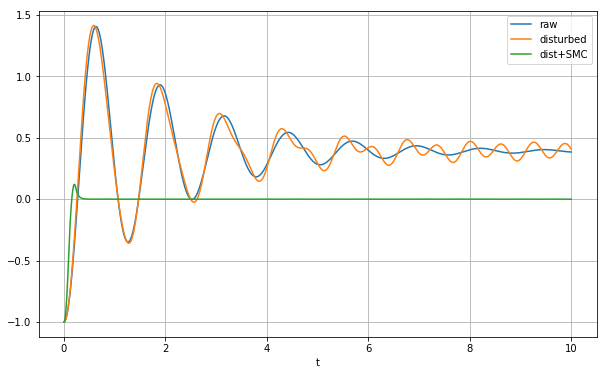

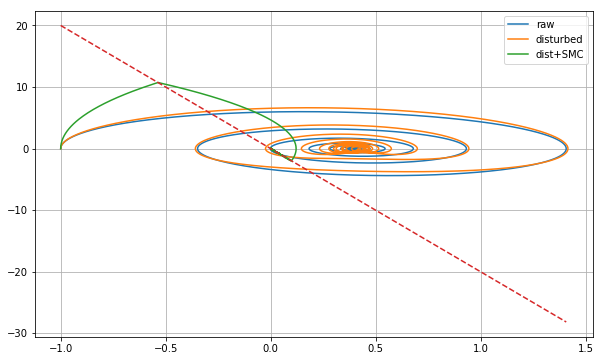

In [7]:
# Plot the solution...
fig0 = plt.figure(0, figsize=(10,6))
plt.plot(t, sol[:,0], label='x')
plt.xlabel('t')
plt.grid(True)
leg = ['raw','disturbed','dist+SMC']
plt.legend(leg)

smc_range_x0 = np.array([np.amin(sol[:,0,0]),np.amax(sol[:,0,0])])
smc_range_x1 = -c[0]/c[1]*smc_range_x0
fig0 = plt.figure(1, figsize=(10,6))
plt.plot(sol[:,0], sol[:,1], label='xd vs x')
plt.plot(smc_range_x0,smc_range_x1,'--')
plt.grid(True)
plt.legend(leg)